In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import os
import pickle
import random
import pandas as pd



# Load Last Graph

In [3]:
PROJECT_PATH = os.getcwd()
PATH = os.path.join(PROJECT_PATH, "..","output", "graph.gml")
# Load the graph from the file
G = nx.read_gml(PATH)

In [61]:
DIRECTED = False
if not DIRECTED:
    G =  G.to_undirected()



# Visualize the graph

C:\Users\EdenYavin\AppData\Local\Temp\ipykernel_10056\2418441246.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes = random.sample(G.nodes(), 20)


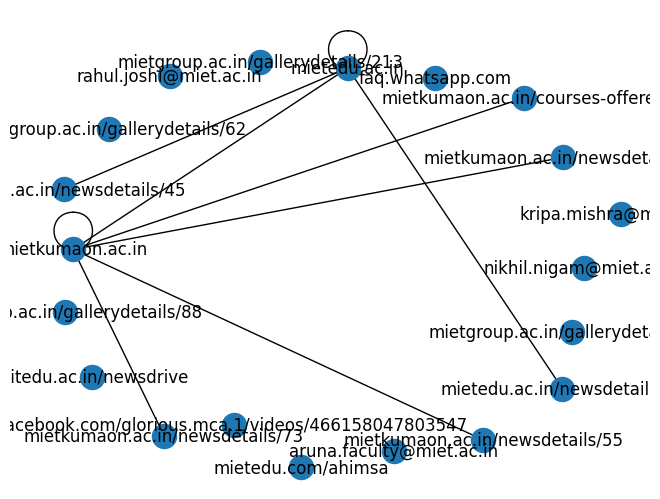

In [4]:
# select a random subset of nodes
nodes = random.sample(G.nodes(), 20)

# create a subgraph from the selected nodes
subgraph = G.subgraph(nodes)

pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True)
plt.show()

# Build Corpus: Word = Email, Document = URL

In [63]:
urls = [n for n, data in G.nodes(data=True) if data and data['type'] == 'url']
corpus = []
doc_idx = {}
idx = 0 # The index of the url in the corpus
for url in urls:
    # Get all the neighbors for that url and check for emails
    url_emails = [n for n in G.neighbors(url) if G.nodes[n]['type'] == 'email']
    if url_emails:
        # Some urls are connected to only other urls meaning that no emails were found in the url
        corpus.append(" ".join(url_emails))
        # Save the index of the url in the corpus
        doc_idx[url] = idx
        idx += 1 # Increment the ind

corpus

['contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in',
 'contact@miet.ac.in nilay.nandi@miet.ac.in Shibam.das@miet.ac.in apkavivek@gmail.com iqra.rahat@miet.ac.in prabhash.tripathi@miet.ac.in anjana.sharma@miet.ac.in principalpharmacy@miet.ac.in vishi.khattri@miet.ac.in avnesh.singh@miet.ac.in anurag.chaudhary@miet.ac.in ankit040997@gmail.com angesh.kumar@miet.ac.in madhusmita.sahu@miet.ac.in pooja.yadav@miet.ac.in garima.agarwal@miet.ac.in summaiya.ansari@miet.ac.in ravindra86756@gmail.com.in principal.pharmacy@miet.ac.in nalini.sahoo@miet.ac.in anoop.kumar@miet.ac.in rashi.fauzdar@miet.ac.in Kartik.sharma@miet.ac.in vrish.ashwlayan@miet.ac.in sujata.thakur.@miet.ac.in priya.masand@miet.ac.in Email-H

# TF-IDF

In [64]:
EMAIL_REGEX = r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+"

vectorizer = TfidfVectorizer(use_idf=True, lowercase=False, smooth_idf=True, token_pattern=EMAIL_REGEX)  # No lowercase to preserve the emails


tfidf_matrix = vectorizer.fit_transform(corpus)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# add tf-idf scores to the edge weights between emails and urls
for url, idx in doc_idx.items():
    for email in G.neighbors(url):
        try:
            G.edges[url, email]['weight'] = tfidf_df.loc[idx, email].item()
        except KeyError:
            # The neighbor is an url and not an email
            pass


idx_doc = dict((v,k) for k,v in doc_idx.items())
# Let's replace the indexes with the url names
tfidf_df = tfidf_df.rename(idx_doc)

tfidf_df.head()

,Aakansha.vishnoi@miet.ac.in,Devendra.arora@miet.ac.in,Email-Helpline@Antiragging.In,Gmail@miet.ac.inEnter,Kartik.sharma@miet.ac.in,Lokendra.Kumar@miet.ac.in,Neha.goel@miet.ac.in,Nidhi.sharma.mca@miet.ac.in,Nidhi.sharma@miet.ac.in,RENU.SHARMA@MIET.AC.IN,...,upasana.gupta@miet.ac.in,upasana.rani@miet.ac.in,vaishali.goel@miet.ac.in,vandna.rathor@miet.ac.in,vinay.singhal@miet.ac.in,vipin.garg@miet.ac.in,vishal.saini@miet.ac.in,vishi.khattri@miet.ac.in,vivek.bhardwaj@miet.ac.in,vrish.ashwlayan@miet.ac.in
miet.ac.in,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
miet.ac.in/online-registration,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
miet.ac.in/institute-best-practices,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
miet.ac.in/background,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
miet.ac.in/vision-mission,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# Rows are url, columns are emails
tfidf_df.shape

(93, 164)

# Node Analysis

## Emails Nodes

In [66]:
emails_nodes = []
for node, data in G.nodes(data=True):
    if data and data['type'] == 'email':
        emails_nodes.append(node)

print(f"Number of nodes: {len(emails_nodes)}")

Number of nodes: 164


### Scores Analysis

<Axes: >

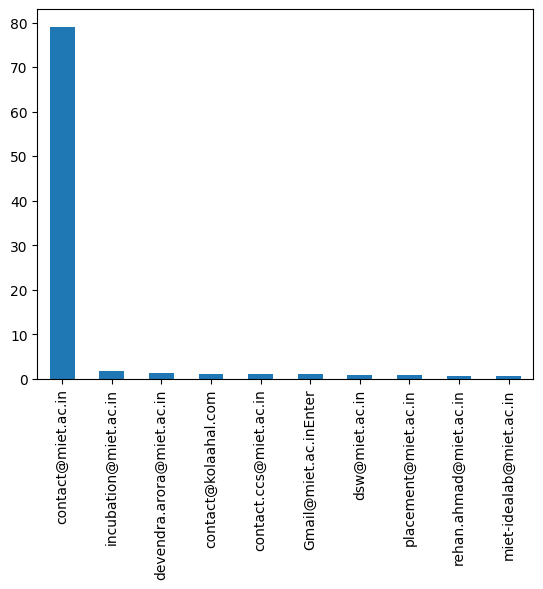

In [67]:
# Lets plot the top words by summing the TF-IDF of the words accross all documents. The higher the score the more chance the email is a garbage email
tfidf_df.sum().sort_values(ascending=False).head(10).plot(kind='bar')

<Axes: >

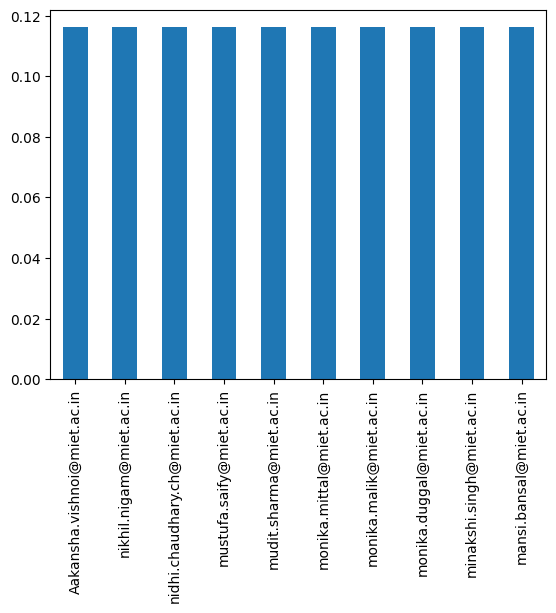

In [68]:
# Lets to the reverse as well
tfidf_df.sum().sort_values(ascending=True).head(10).plot(kind='bar')

<Axes: >

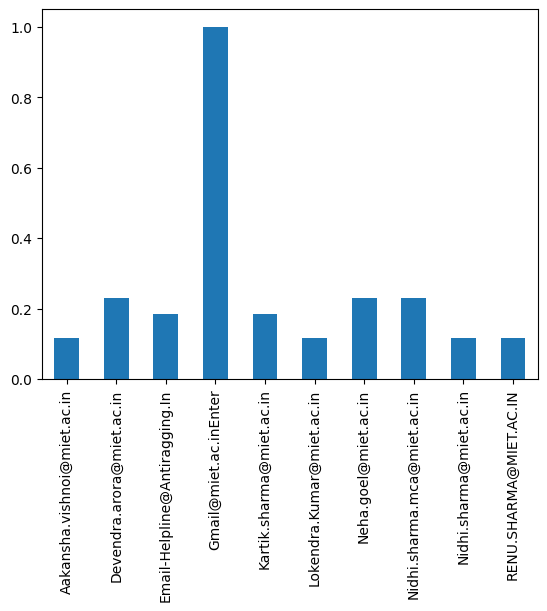

In [69]:
# Lets also take a random
tfidf_df.sum().head(10).plot(kind='bar')

# We can see here an example for an email that look fake - Gmail@miet.ac.in

## URL nodes

In [70]:
url_nodes = []
for node, data in G.nodes(data=True):

    if data and data['type'] == 'url':
        url_nodes.append(node)

print(f"Number of nodes: {len(url_nodes)}")

Number of nodes: 1111


### Scores Analysis

In [31]:
url_nodes

['miet.ac.in',
 'miet.360-visit.in',
 'miet.ac.in/feepayment-new',
 'miet.ac.in/feepayment-existing',
 'miet.ac.in/online-registration',
 'miet.ac.in/institute-best-practices',
 'miet.ac.in/background',
 'miet.ac.in/vision-mission',
 'miet.ac.in/chairman',
 'miet.ac.in/vice-chairman',
 'miet.ac.in/director',
 'miet.ac.in/board-of-governor',
 'miet.ac.in/important-functionaries',
 'miet.ac.in/accreditation',
 'miet.ac.in/approval-affiliation',
 'miet.ac.in/iqac',
 'miet.ac.in/committee',
 'miet.ac.in/btech',
 'miet.ac.in/pharmacy',
 'miet.ac.in/applied-science-engineering',
 'miet.ac.in/mtech',
 'miet.ac.in/mpharm',
 'miet.ac.in/mca3',
 'miet.ac.in/mietb-school',
 'mietedu.com',
 'miet.ac.in/research-papers',
 'miet.ac.in/patents',
 'miet.ac.in/international-connectmiet',
 'miet.ac.in/special-training',
 'miet.ac.in/departments',
 'miet.ac.in/ordinance',
 'miet.ac.in/syllabus',
 'miet.ac.in/academic-pedagogy',
 'miet.ac.in/research-development',
 'miet.ac.in/academic-calendar',
 'miet.a

In [52]:
# We want to look at only URL with email attached to them to see their TF-IDF based on the sum TF-IDF of the email attached to them,
# We need to transpose the documents to get the document as the index
tfidf_df.T.sum().head(10)


miet.ac.in                             1.0
miet.ac.in/online-registration         1.0
miet.ac.in/institute-best-practices    1.0
miet.ac.in/background                  1.0
miet.ac.in/vision-mission              1.0
miet.ac.in/chairman                    1.0
miet.ac.in/vice-chairman               1.0
miet.ac.in/director                    1.0
miet.ac.in/board-of-governor           1.0
miet.ac.in/important-functionaries     1.0
dtype: float64

<Axes: >

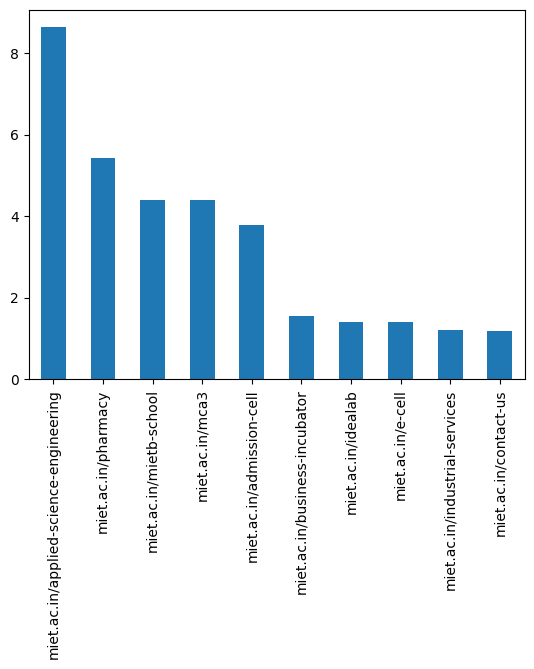

In [53]:
# Lets look at the dominant URLs
tfidf_df.T.sum().sort_values(ascending=False).head(10).plot(kind='bar')

<Axes: >

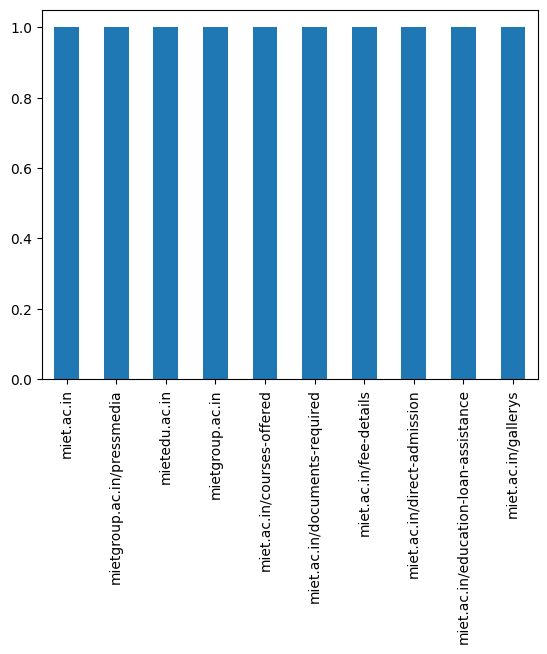

In [54]:
# Lets look at the less dominant URLs
tfidf_df.T.sum().sort_values(ascending=True).head(10).plot(kind='bar')

In [57]:
# Lets look at the different emails number between the dominant URLs and non-dominant URLs
top_5 = tfidf_df.T.sum().sort_values(ascending=False).head(5).index.tolist()
bottom_5 = tfidf_df.T.sum().sort_values(ascending=True).head(5).index.tolist()

for node in top_5:
    neighbors = [n for n in G.neighbors(node) if G.nodes[n]['type'] == "email"]
    print(f"Dominant URL: {node}, Number of emails in the URL: {len(neighbors)}")

for node in bottom_5:
    neighbors = [n for n in G.neighbors(node) if G.nodes[n]['type'] == "email"]
    print(f"Lame URL: {node}, Number of emails in the URL: {len(neighbors)}")


Dominant URL: miet.ac.in/applied-science-engineering, Number of emails in the URL: 75
Dominant URL: miet.ac.in/pharmacy, Number of emails in the URL: 30
Dominant URL: miet.ac.in/mietb-school, Number of emails in the URL: 20
Dominant URL: miet.ac.in/mca3, Number of emails in the URL: 20
Dominant URL: miet.ac.in/admission-cell, Number of emails in the URL: 15
Lame URL: miet.ac.in, Number of emails in the URL: 1
Lame URL: mietgroup.ac.in/pressmedia, Number of emails in the URL: 1
Lame URL: mietedu.ac.in, Number of emails in the URL: 1
Lame URL: mietgroup.ac.in, Number of emails in the URL: 1
Lame URL: miet.ac.in/courses-offered, Number of emails in the URL: 1


# Try Different Centrality algorithms

## Note: The importance is only for url in each domain

In [77]:
nodes_for_each_domain = {}

# Create cluster of URL in each domain
for node, data in G.nodes(data=True):
    if data['type'] == 'url':
        nodes_for_each_domain.setdefault(data['domain'], set()).add(node)



nodes_for_each_domain

{'miet.ac.in': {'a2zgroup.co.in',
  'abbott.co.in',
  'accenture.com',
  'accounts.google.com/signin/v2/identifier',
  'aicte-india.org',
  'aktu.ac.in',
  'alokind.com',
  'amdale.com',
  'angloeasterngroup.com',
  'aon.com/india',
  'apollohospitals.com',
  'atninfratech.com',
  'axisbank.com',
  'bharti.com',
  'bhaskar.com',
  'birlasoft.com',
  'cargill.co.in',
  'carrefour.com',
  'cims.mastersofterp.in',
  'cimsstudent.mastersofterp.in',
  'cognizant.com',
  'cumi-murugappa.com',
  'dcmsr.com',
  'docs.google.com/forms/d/1Q_pj67zhHn0GAXETtGo3-p8M8TYlqqnvNUCzRYjs5sI/viewform',
  'docs.google.com/forms/d/e/1FAIpQLSc258voagvwA9zSnOMJFnjQ5vWpdnz-fA19gihhxPi7Nr5Oug/viewform',
  'docs.google.com/forms/d/e/1FAIpQLSce-HMNfhKS38idFjCHRWzGgTx4CYcAc4Tdgb4I-cBNcx01WQ/formrestricted',
  'doi.org/10.1016/j.chemphyslip.2020.104890',
  'doi.org/10.1016/j.jddst.2019.101224',
  'doi.org/10.1016/j.jddst.2020.101632',
  'doi.org/10.2174/1389557518666180928154004',
  'doi.org/10.22270/jddt.v9i4-A.33

## Degree - In degree centrality: The in-degree centrality of a node in a directed graph is the sum of weights of all incoming edges to that node. Nodes with high in-degree centrality are often seen as more important or influential, as they receive a lot of connections from other nodes.

In [79]:
degree_centrality_per_domain = {}

degree_method = nx.degree_centrality if not DIRECTED else nx.in_degree_centrality

degree_in = degree_method(G)
for domain, cluster in nodes_for_each_domain.items():
    degree_centrality_per_domain[domain] = {}
    for node in cluster:
        degree_centrality_per_domain[domain][node] = degree_in[node]

    degree_centrality_per_domain[domain] = sorted(degree_centrality_per_domain[domain].items(), key=lambda x: x[1], reverse=True)

degree_centrality_per_domain

# We can see that this measure is not good since applied-science which is considered the best URL is not first

{'miet.ac.in': [('mietgroup.ac.in/pressmedia', 0.23861852433281006),
  ('mietkumaon.ac.in', 0.16797488226059656),
  ('mietedu.com', 0.15934065934065936),
  ('miet.ac.in/applied-science-engineering', 0.14835164835164835),
  ('mietedu.ac.in', 0.1467817896389325),
  ('miet.ac.in/gallerys', 0.14521193092621665),
  ('mitedu.ac.in', 0.14442700156985872),
  ('miet.ac.in/our-recruiters', 0.14285714285714288),
  ('miet.ac.in/pharmacy', 0.1240188383045526),
  ('miet.ac.in/download-formats', 0.1240188383045526),
  ('miet.ac.in/mca3', 0.11538461538461539),
  ('miet.ac.in/mietb-school', 0.10910518053375197),
  ('miet.ac.in/set', 0.10832025117739404),
  ('miet.ac.in/admission-cell', 0.1012558869701727),
  ('miet.ac.in/btech', 0.1012558869701727),
  ('miet.ac.in/newsdrive', 0.1012558869701727),
  ('miet.ac.in/departments', 0.09890109890109891),
  ('miet.ac.in/industrial-services', 0.09654631083202513),
  ('miet.ac.in/central-library', 0.09654631083202513),
  ('miet.ac.in/criteria-i', 0.09576138147566

## PageRank - PageRank is a measure of centrality that takes into account both the number and quality of links to a node. It assigns a score to each node based on the importance of other nodes that link to it. Nodes with high PageRank scores are often seen as more important or influential.

In [ ]:
pagerank_per_domain = {}
pagerank = nx.pagerank(G, weight='weight')
for domain, cluster in nodes_for_each_domain.items():
    pagerank_per_domain[domain] = {}
    for node in cluster:
        pagerank_per_domain[domain][node] = pagerank[node]

    pagerank_per_domain[domain] = sorted(pagerank_per_domain[domain].items(), key=lambda x: x[1], reverse=True)

pagerank_per_domain

# We can see that this algorithm is very good since the url with most important email came up first in the list

## Closness: measures the mean distance from one node to any other node. The more central a node is, the closer it is to all the other nodes

In [81]:
closeness_per_domain = {}
closeness = nx.closeness_centrality(G, distance='weight')
for domain, cluster in nodes_for_each_domain.items():
    closeness_per_domain[domain] = {}
    for node in cluster:
        closeness_per_domain[domain][node] = closeness[node]

    closeness_per_domain[domain] = sorted(closeness_per_domain[domain].items(), key=lambda x: x[1], reverse=True)

closeness_per_domain

# We can see that this measure is not good since applied-science which is considered the best URL is not first

{'miet.ac.in': [('miet.ac.in/csharpcorner', 37.26324748041812),
  ('miet.ac.in/gallerydetails/55', 37.26324748041812),
  ('miet.ac.in/mca', 37.26324748041812),
  ('miet.ac.in/computer-science-engineering-IOT', 37.26324748041812),
  ('miet.ac.in/gallerydetails/38', 37.26324748041812),
  ('miet.ac.in/mechanical-engineering', 37.26324748041812),
  ('miet.ac.in/computer-science-engineering-AI-ML', 37.26324748041812),
  ('miet.ac.in/gallerydetails/33', 37.26324748041812),
  ('miet.ac.in/international-connectmiet', 37.26324748041812),
  ('miet.ac.in/kolaahal', 37.26324748041812),
  ('peerreviewcentral.com', 37.26324748041812),
  ('miet.ac.in/newsdetails/514', 37.26324748041812),
  ('doi.org/10.2174/1389557518666180928154004', 37.26324748041812),
  ('miet.ac.in/sanskriti', 37.26324748041812),
  ('miet.ac.in/set3', 37.26324748041812),
  ('miet.ac.in/placementdetails/267', 37.26324748041812),
  ('graphiteartland.cuccfree.com', 37.26324748041812),
  ('miet.ac.in/special-training', 37.26324748041

## Betweeness: Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes. In a directed weighted graph, the betweenness centrality algorithm takes into account both the weights and directions of the edges.

In [82]:
between_per_domain = {}
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True, endpoints=True)
for domain, cluster in nodes_for_each_domain.items():
    between_per_domain[domain] = {}
    for node in cluster:
        between_per_domain[domain][node] = betweenness[node]

    between_per_domain[domain] = sorted(between_per_domain[domain].items(), key=lambda x: x[1], reverse=True)

between_per_domain

# We can see that this measure is not good since applied-science which is considered the best URL is not first

{'miet.ac.in': [('mietgroup.ac.in/pressmedia', 2.7862553245259837e+122),
  ('miet.ac.in/our-recruiters', 1.0475680475123184e+105),
  ('miet.ac.in/pharmacy', 6.244660896539974e+97),
  ('miet.ac.in/mca3', 1.951456530168742e+96),
  ('miet.ac.in/btech', 3.048778663024529e+94),
  ('miet.ac.in', 1.876211712485205e+94),
  ('miet.ac.in/online-registration', 7.621946231669703e+93),
  ('miet.ac.in/institute-best-practices', 3.8109731158348516e+93),
  ('miet.ac.in/mietb-school', 1.905719267742912e+93),
  ('miet.ac.in/background', 1.9054865579174258e+93),
  ('miet.ac.in/vision-mission', 9.527432789587129e+92),
  ('miet.ac.in/chairman', 4.7637163947935645e+92),
  ('miet.ac.in/vice-chairman', 2.3818581973967823e+92),
  ('miet.ac.in/director', 1.1909290986983911e+92),
  ('miet.ac.in/board-of-governor', 5.954645493491956e+91),
  ('miet.ac.in/approval-affiliation', 2.977322746745978e+91),
  ('miet.ac.in/important-functionaries', 2.977322746745978e+91),
  ('miet.ac.in/departments', 2.674575117447264e+91

## Eigenvector: Eigenvector centrality is a measure of the influence of a node in a network, where a node's influence is proportional to the influence of its neighbors

In [84]:
eigen_per_domain = {}
eigen_cen = nx.eigenvector_centrality(G, weight='weight', max_iter=50000)
for domain, cluster in nodes_for_each_domain.items():
    eigen_per_domain[domain] = {}
    for node in cluster:
        eigen_per_domain[domain][node] = eigen_cen[node]

    eigen_per_domain[domain] = sorted(eigen_per_domain[domain].items(), key=lambda x: x[1], reverse=True)

eigen_per_domain

# We can see that this algorithm is very good since the url with most important email came up first in the list

{'miet.ac.in': [('miet.ac.in/international-connectmiet', 0.07996205389652027),
  ('miet.ac.in/special-training', 0.07996205389652027),
  ('mietgroup.ac.in', 0.07996205389652027),
  ('miet.ac.in/gallerys', 0.07996205389652027),
  ('miet.ac.in/academic-pedagogy', 0.07996205389652027),
  ('miet.ac.in/mtech', 0.07996205389652027),
  ('miet.ac.in/approval-affiliation', 0.07996205389652027),
  ('miet.ac.in/direct-admission', 0.07996205389652027),
  ('miet.ac.in/why-miet', 0.07996205389652027),
  ('miet.ac.in/social-service', 0.07996205389652027),
  ('miet.ac.in/central-library', 0.07996205389652027),
  ('miet.ac.in/syllabus', 0.07996205389652027),
  ('miet.ac.in', 0.07996205389652027),
  ('miet.ac.in/extracircular', 0.07996205389652027),
  ('miet.ac.in/faculty-residence-guest-house', 0.07996205389652027),
  ('miet.ac.in/iqac', 0.07996205389652027),
  ('miet.ac.in/academic-calendar', 0.07996205389652027),
  ('miet.ac.in/computational-facilities', 0.07996205389652027),
  ('miet.ac.in/newsdetai

### For example, lets investigate the largest cluster (domain)

In [85]:
# Find the largest cluster
max(dict((d,len(v)) for d,v in nodes_for_each_domain.items()).items(), key=lambda x: x[1])

('miet.ac.in', 444)

### Let's look at the largest cluster and how it's top 5 looks like

In [86]:
# Remove email nodes
valid_nodes = [n for n in pagerank_per_domain['miet.ac.in'] if "@" not in n[0]]
# Find the top 5 in the cluster
top_5 = valid_nodes[:5]
top_5

[('miet.ac.in/applied-science-engineering', 0.08365496141592223),
 ('miet.ac.in/pharmacy', 0.03330605073108756),
 ('miet.ac.in/mietb-school', 0.02123714743976),
 ('miet.ac.in/mca3', 0.0204424005927483),
 ('miet.ac.in/admission-cell', 0.014231066091989717)]

In [87]:
# Lets get the neighbors to see how it looks like
top_nodes = [tup[0] for tup in top_5]
neighbors = [list(G.neighbors(n)) for n in top_nodes]


In [88]:
print(neighbors[0])

['miet.ac.in', 'contact@miet.ac.in', 'miet.360-visit.in', 'miet.ac.in/feepayment-new', 'miet.ac.in/feepayment-existing', 'miet.ac.in/online-registration', 'miet.ac.in/institute-best-practices', 'miet.ac.in/background', 'miet.ac.in/vision-mission', 'miet.ac.in/chairman', 'miet.ac.in/vice-chairman', 'miet.ac.in/director', 'miet.ac.in/board-of-governor', 'miet.ac.in/important-functionaries', 'miet.ac.in/accreditation', 'miet.ac.in/approval-affiliation', 'miet.ac.in/iqac', 'miet.ac.in/committee', 'miet.ac.in/btech', 'miet.ac.in/pharmacy', 'miet.ac.in/index.php', 'miet.ac.in/academic-calendar', 'miet.ac.in/academic-pedagogy', 'miet.ac.in/admission-cell', 'miet.ac.in/annualevent', 'miet.ac.in/anti-ragging-squad', 'shivali.rastogi@miet.ac.in', 'madhu.singh@miet.ac.in', 'vivek.bhardwaj@miet.ac.in', 'deepa.sehrawat@miet.ac.in', 'upasana.rani@miet.ac.in', 'indrajit.kumar@miet.ac.in', 'radhika.jindal@miet.ac.in', 'ansari.aqsa0695@gmail.com', 'mahendra.singh@miet.ac.in', 'prashant.jindal@miet.ac.i

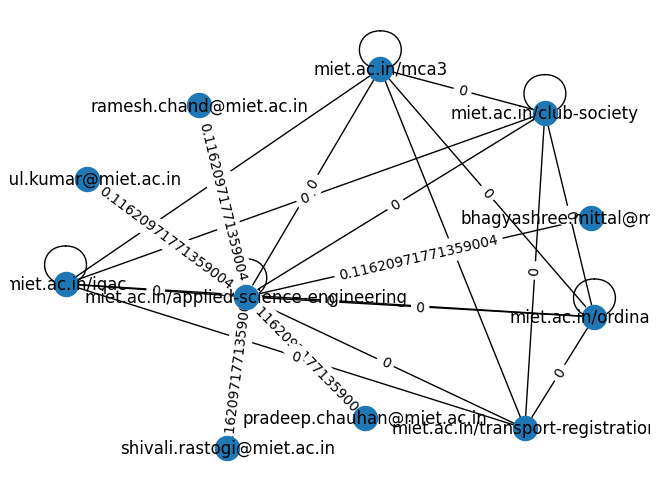

In [90]:
# Take random so that the graph will be seen
emails, urls = [n for n in neighbors[0] if 'type' in G.nodes[n] and G.nodes[n]['type'] == 'email'], [n for n in neighbors[0] if 'type' in G.nodes[n] and G.nodes[n]['type'] == 'url']
sample = [top_nodes[0]] + random.sample(emails, 5) + random.sample(urls, 5)
sub = G.subgraph(sample)


pos = nx.spring_layout(sub, k=1)
nx.draw(sub, pos, with_labels=True)
labels = nx.get_edge_attributes(sub, 'weight')
nx.draw_networkx_edge_labels(sub, pos, edge_labels={(u, v): d['weight'] for u, v, d in sub.edges(data=True)})
plt.show()

# Seems like indeed the nodes that are chosen to have a high concentration of emails and link with emails